# _(Wong & Wang, 2006)_ Decision model

Implementation of the paper:

- [1] Wong, K.-F. & Wang, X.-J. A Recurrent Network Mechanism 
  of Time Integration in Perceptual Decisions. 
  J. Neurosci. 26, 1314–1328 (2006).
  
We adopt a simplified version from: 

- [2] Stanford University, BIOE 332: Large-Scale Neural Modeling, 
    Kwabena Boahen & Tatiana Engel, 2013, online available.

In [1]:
import brainpy as bp
import numpy as np
from collections import OrderedDict

bp.backend.set(backend='numpy', dt=0.05)

We use the model from Ref. [2], which is derived from the simplest form (without AMPA at recurrent synapses) of the original paper (Ref. [1]) :

$$ \frac {dS_i}{dt} = - \frac{S_i}{\tau_S} + (1-S_i)\gamma f(I_{{\rm syn}, i}) $$

$$ f(I_{{\rm syn}, i}) = \frac {a I_{{\rm syn}, i} - b}{1-{\rm exp} [-d(aI_{{\rm syn}, i} - b)]} $$

$$ I_{{\rm syn}, 1} = J_{11} S_1 - J_{12} S_2 +I_0 + I_1 $$

$$ I_{{\rm syn}, 2} = J_{22} S_2 - J_{21} S_1 +I_0 + I_2 $$

$$ I_i = J_{\rm A, ext} \mu_0 (1 +- c') $$


where $i=1,2$ labels the selective population. 

Parameter values for the input-output function $H_i$ are $a = 270$(VnC)$^{-1}, b = 108$Hz, and $d = 0.154$s.

The kinetic parameters are $\gamma = 0.641, \tau_s = 60$ms.

$J_{ij}$ represents the effective network connectivity from j to i, and we will use $J_{11} = J_{22} = 0.3725$ nA, $J_{12} = J_{21} = 0.1137$nA, and $J_{\rm A, ext} = 5.2 \times 10^{-4}$nA$\cdot$Hz$^{-1}$.

The overall effective external inputs is $I_0 = 0.3297$nA.

In [2]:
class Decision(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, coh, tau_s=.06, gamma=0.641,
                J_rec = .3725, J_inh = .1137, 
                I_0=.3297, JAext = .00117,
                a = 270., b=108., d=0.154,
                **kwargs):
        # parameters
        self.coh = coh
        self.tau_s = tau_s
        self.gamma = gamma
        self.J_rec = J_rec
        self.J_inh = J_inh
        self.I0 = I_0
        self.JAext = JAext
        self.a = a
        self.b = b
        self.d = d

        # variables
        self.s1 = bp.ops.ones(size) * .06
        self.s2 = bp.ops.ones(size) * .06
        self.input = bp.ops.zeros(size)

        super(Decision, self).__init__(size=size, **kwargs)


    @staticmethod
    @bp.odeint(method='rk4')
    def integral(s1, s2, t, I, coh, JAext, J_rec, J_inh, I_0, b, d, a, tau_s, gamma): 
        I1 = JAext * I * (1. + coh) 
        I2 = JAext * I * (1. - coh) 

        I_syn1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        r1 = (a * I_syn1 - b) / (1. - bp.ops.exp(-d * (a * I_syn1 - b)))
        ds1dt = - s1 / tau_s + (1. - s1) * gamma * r1
        
        I_syn2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        r2 = (a * I_syn2 - b) / (1. - bp.ops.exp(-d * (a * I_syn2 - b)))
        ds2dt = - s2 / tau_s + (1. - s2) * gamma * r2        

        return ds1dt, ds2dt


    def update(self, _t):
        self.s1, self.s2 = self.integral(self.s1, self.s2, _t, 
                                        self.input, self.coh, self.JAext, self.J_rec, 
                                        self.J_inh, self.I0, self.b, self.d, 
                                        self.a, self.tau_s, self.gamma)
        self.input[:] = 0.

## Phase plane analysis

We will replicate Fig. 5 from Ref. [1].

**No stimulus**

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.06176109215560733, s1=0.061761097890810475 is a stable node.
Fixed point #2 at s2=0.029354239100062428, s1=0.18815448592736211 is a saddle node.
Fixed point #3 at s2=0.0042468423702408655, s1=0.6303045696241589 is a stable node.
Fixed point #4 at s2=0.6303045696241589, s1=0.004246842370235128 is a stable node.
Fixed point #5 at s2=0.18815439944520335, s1=0.029354240536530615 is a saddle node.
plot vector field ...


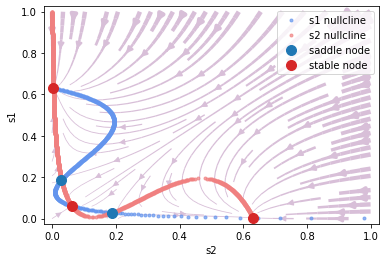

In [3]:
pars = dict(tau_s=.06, gamma=0.641,
                J_rec = .3725, J_inh = .1137, 
                I_0=.3297, JAext = .00117,
                b=108., d=0.154, a = 270.)

pars['I'] = 0.
pars['coh'] = 0.

phase = bp.analysis.PhasePlane(Decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

**Symmetric stimulus (0% coherence)**

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.6993504413888704, s1=0.011622049527244513 is a stable node.
Fixed point #2 at s2=0.49867489858358865, s1=0.49867489858358865 is a saddle node.
Fixed point #3 at s2=0.011622051540013747, s1=0.6993504355529327 is a stable node.
plot vector field ...


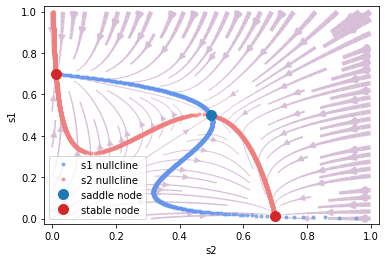

In [4]:
pars['I'] = 30.
pars['coh'] = 0.

phase = bp.analysis.PhasePlane(Decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

**Biased stimulus (14% coherence)**

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.009368536785257226, s1=0.706534542997363 is a stable node.
Fixed point #2 at s2=0.6914853214021102, s1=0.014516767247977323 is a stable node.
Fixed point #3 at s2=0.5408174270167093, s1=0.43078964580182816 is a saddle node.
plot vector field ...


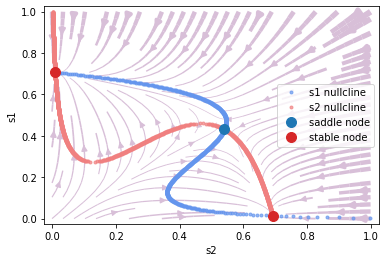

In [5]:
pars['I'] = 30.
pars['coh'] = 0.14

phase = bp.analysis.PhasePlane(Decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

**Biased stimulus (51.2% coherence)**

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.5673124813731691, s1=0.2864701069327971 is a saddle node.
Fixed point #2 at s2=0.6655747347157656, s1=0.027835279565912054 is a stable node.
Fixed point #3 at s2=0.005397687847426814, s1=0.7231453520305031 is a stable node.
plot vector field ...


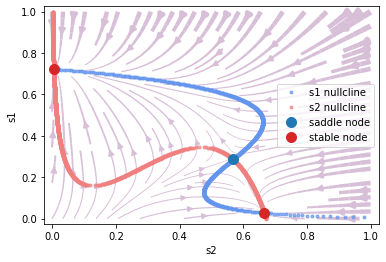

In [6]:
pars['I'] = 30.
pars['coh'] = 0.512

phase = bp.analysis.PhasePlane(Decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

**Stimulus to one population only (100% coherence)**

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.0026865954387078755, s1=0.7410985604497689 is a stable node.
plot vector field ...


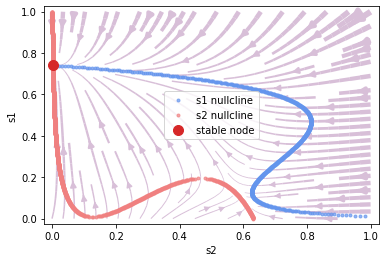

In [7]:
pars['I'] = 30.
pars['coh'] = 1.

phase = bp.analysis.PhasePlane(Decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)